In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import sys
from pylab import *
import os
import urllib.request
import itertools
import seaborn as sns
import numpy as np
import math
import random
from adjustText import adjust_text

In [31]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

pd.options.mode.chained_assignment = None

In [32]:
YEAR = 2020
data = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(YEAR) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)

In [33]:
#remove deprecated columns
data.drop(['passer_player_name', 'passer_player_id',
           'rusher_player_name', 'rusher_player_id',
           'receiver_player_name', 'receiver_player_id'],
          axis=1, inplace=True)

In [34]:
#remove plays that are not penalties, passes, or runs or have null epa
data = data.loc[(data.play_type.isin(['no_play','pass','run'])) & (data.epa.isna()==False)]

In [35]:
#make sure QB scrambles are labeled appropriately
data.play_type.loc[data['pass']==1] = 'pass'
data.play_type.loc[data.rush==1] = 'run'

In [36]:
#clean up index after data clean up
data.reset_index(drop=True, inplace=True)

In [37]:
#data = data.loc[(data['week'] >= 6)]

In [53]:
#group by without making it the index!
qbs = data.groupby(['passer', 'posteam'], as_index=False).agg({'epa':'mean',
                                                               'cpoe':'mean',
                                                               'air_yards':'mean',
                                                               'play_id':'count'})

In [54]:
qbs.sort_values('epa', ascending=False, inplace=True)

#round data!
qbs.round(2)

#rename columns easily!
qbs.columns = ['Player', 'Team', 'EPA per Dropback', 'CPOE', 'aDOT', 'Dropbacks']

In [58]:
#adjust total dropbacks as season goes
qbs = qbs.loc[(qbs['Dropbacks'] > 200)]
#qbs

In [41]:
#cols = data.columns.tolist()
#cols

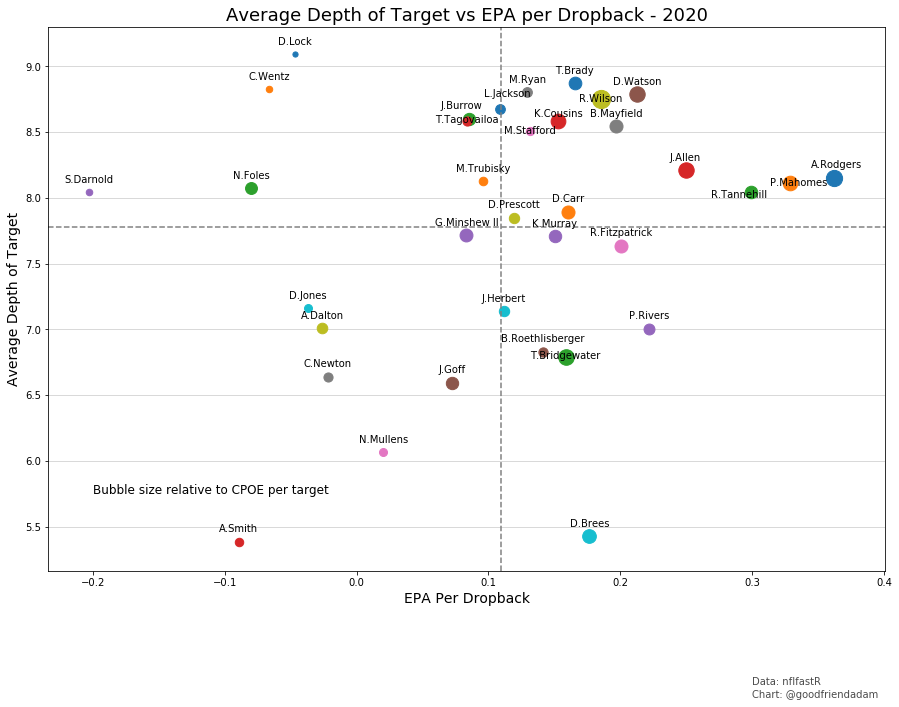

In [60]:
#create figure
fig, ax = plt.subplots(figsize=(15,10))

#make scatter plot with data -alternative?
#x = qbs['EPA per Dropback']
#y = qbs['aDOT']
#numcolors = len(qbs.index)
#c = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#             for i in range(numcolors)]#np.arange(len(qbs.index)) #np.random.randint(1, 50, size=len(qbs.index))
#s = (pow(abs(qbs['CPOE']+10), 2))
#scatter = ax.scatter(x, y, c=c, s=s)

#add data to chart
for player, row in qbs.iterrows():
    scatter = plt.scatter(row['EPA per Dropback'], row['aDOT'], label=player, s=(pow(abs(row['CPOE']+10), 2)))
    #plt.text(row['EPA per Dropback']-0.02, row['aDOT']+.1, row['Player'])
    #plt.text(x0, y0, frameon=False, fontsize=4)

#append names and allows to adjust below
texts = []
for x, y, s in zip(qbs['EPA per Dropback'], qbs['aDOT'], qbs['Player']):
    texts.append(plt.text(x#-0.015
                          , y+.05
                          , s))
    
#add grid
ax.grid(zorder=0, alpha=.6, axis='y')
ax.set_axisbelow(True)

#set average aDOT
ax.axhline(y=qbs['aDOT'].mean(), linestyle='--', color='grey')

#set average epa
ax.axvline(x=qbs['EPA per Dropback'].mean(), linestyle='--', color='grey')

# Calculate the simple average of the data
adot_mean = [np.mean(qbs['aDOT'])]
epa_mean = [np.mean(qbs['EPA per Dropback'])]
             
# Plot the average line
mean_line = ax.plot(epa_mean, adot_mean, label='Mean', linestyle='--')

#add labels and text
ax.set_xlabel('EPA Per Dropback', fontsize=14)
ax.set_ylabel('Average Depth of Target', fontsize=14)
ax.text(-0.2, 5.75, 'Bubble size relative to CPOE per target', fontsize=12, color='black')
ax.set_title('Average Depth of Target vs EPA per Dropback - 2020', fontsize=18)
ax.text(0.3, 4.2, 'Chart: @goodfriendadam', fontsize=10, alpha=.7)
ax.text(0.3, 4.3, 'Data: nflfastR', fontsize=10, alpha=.7)
#plt.legend()

#adjust name spacing so no overlaps
adjust_text(texts, autoalign='y',
            only_move={'points':'y', 'text':'xy'}) #force_points=0.15)
#            arrowprops=dict(arrowstyle="->", color='r', lw=0.5)

#plt.legend(*scatter.legend_elements("sizes", num=6))

plt.savefig(os.getcwd() + '\\output\\adotvsepa.png',dpi=400)